## Modeling scATAC-seq data with a kNN graph (pancreatic endocrinogenesis, multiome) [Klein et al. 2023]

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import os
import seaborn

In [54]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [55]:
import pandas as pd
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [56]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [57]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [59]:
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cpu


In [60]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [61]:
import scanpy as sc

In [62]:
# atac_path = '../../../annotations/scatac/ancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
all_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_atac.h5ad'
rna_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_rna.h5ad'
if not os.path.exists(atac_path):
    print('preparing atac...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    atac = adata[:,adata.var.modality == 'ATAC'].copy()
    print(atac.shape)
    atac.write(atac_path, compression='lzf')
if not os.path.exists(rna_path):
    print('preparing rna...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    rna = adata[:,adata.var.modality == 'GEX'].copy()
    print(rna.shape)
    rna.write(rna_path, compression='lzf')

In [63]:
atac = sc.read_h5ad(atac_path)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

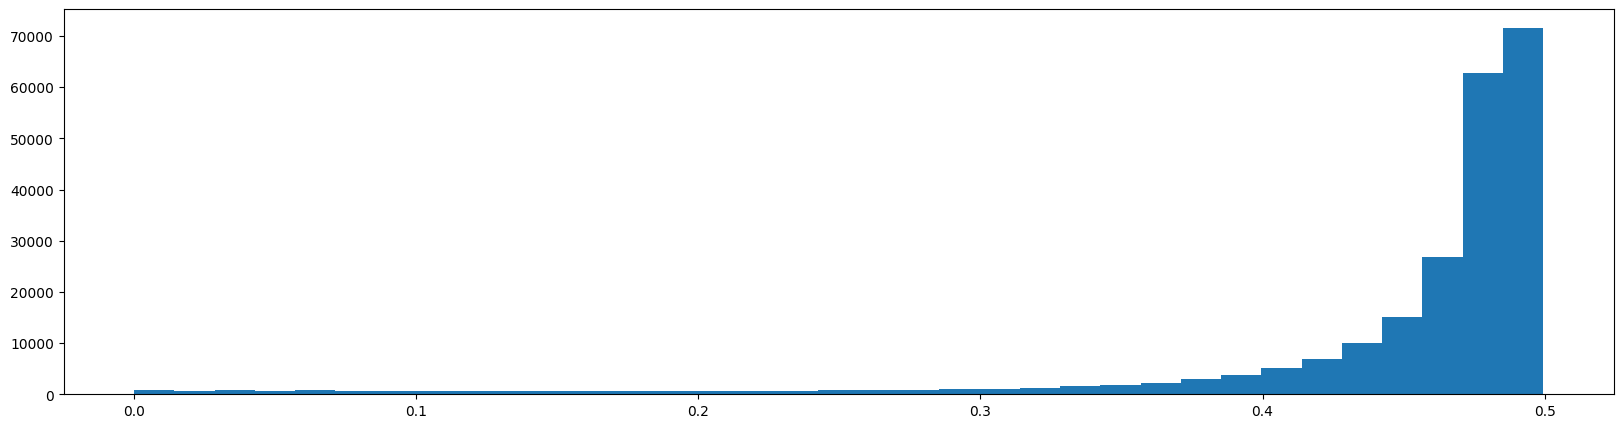

In [64]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [65]:
n_sample_cells = 1000
n_sample_peaks = 100 # int(n_sample_cells * 1.5)
obs_sample = pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(1000, 100)

In [66]:
ad.obs['celltype'].value_counts(), ad.shape

(celltype
 Ngn3 high            249
 Ductal               191
 Imm. Acinar           93
 Prlf. Ductal          93
 Ngn3 low              80
 Mat. Acinar           65
 Fev+                  59
 Fev+ Beta             36
 Beta                  35
 Alpha                 26
 Fev+ Alpha            26
 Eps. progenitors      14
 Epsilon               11
 Fev+ Delta             9
 Delta                  7
 Ngn3 high cycling      6
 Name: count, dtype: int64,
 (1000, 100))

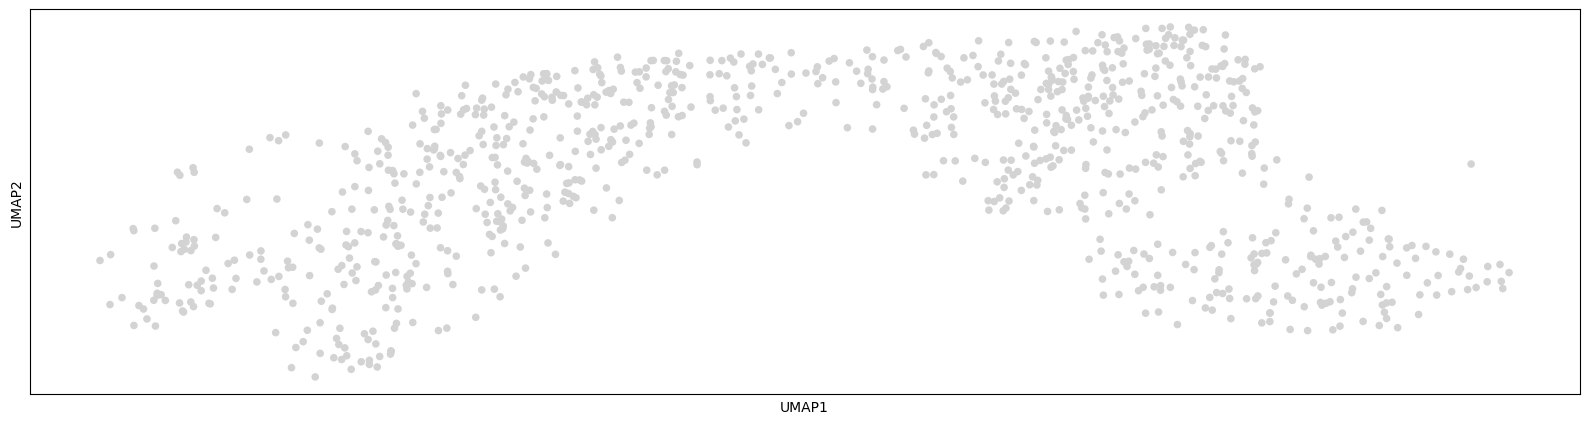

In [67]:
sc.pl.umap(ad)

In [68]:
ad.var

,modality,acc_score,acc_score_rank
1-9742682-9743370,ATAC,0.490365,26787.5
1-11034732-11035603,ATAC,0.489833,31634.5
1-33662988-33663832,ATAC,0.466485,144686.5
1-35889621-35890547,ATAC,0.442901,175806.5
1-55223745-55224602,ATAC,0.487233,55352.5
...,...,...,...
18-77737812-77738706,ATAC,0.451767,166972.5
18-78503710-78504676,ATAC,0.488060,47917.5
19-31871159-31872083,ATAC,0.343421,209242.5
19-43513519-43514426,ATAC,0.478662,108687.0


In [69]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [70]:
extend = 50

ad.var['chr'].value_counts()

chr
chr5     11
chr4     10
chr1      9
chr12     8
chr6      7
chr2      7
chr10     6
chr3      6
chr14     5
chr11     5
chr8      5
chr7      5
chr18     4
chr9      3
chr15     2
chr17     2
chr19     2
chr13     1
chr16     1
chrX      1
Name: count, dtype: int64

In [71]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [72]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmp0j9lid81
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/.conda/envs/mubind/bin/bedtools', 'getfasta', '-fi', '../../../annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmp0j9lid81', '-fo', '/tmp/tmp778pe0oq']
/home/ilibarra/.conda/envs/mubind/bin/bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmp0j9lid81 -fo /tmp/tmp778pe0oq


100

In [73]:
len(seqs)

100

In [74]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [75]:
counts.shape

(100, 1000)

In [76]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [77]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [78]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(100, 1001)

In [79]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(100, 1001)

In [80]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [81]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [82]:
# next_data.index

In [83]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [84]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [85]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(100, 1000)

In [86]:
ad.shape, df.shape

((1000, 100), (100, 1000))

In [87]:
ad = ad[:,~zero_counts].copy()


In [88]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(100000, 3)
1000
batch
0      100
137    100
127    100
128    100
129    100
      ... 
69     100
70     100
71     100
72     100
199    100
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
GCTCTGCGCCACGTGCTTTCTCTGTCCGCCAATGGGCGGAAGCGCCGCGTGAGCTTGCTCCCGCCTCTCCAGCGCGCCCGCGCCAATTGGAAGCTGCAGA,1.0,4.0,0
AGCTCGGGGCTCGAGGCCGACGGTTGCCCGAGGGTCAGATTTTGAATTTCCAGGCCGGGCCCGCCCCTCCCCAAGCCGCAGGGGCGCGCCGGCCGCTCGC,1.0,4.0,0
TGCTCCTCCTCTGTCTCGTGGGTTGGGGAAAAGGGCTGTCACTTTGCTTCGACCCTCCCCTTCCCACCCTCTGGTCTCTCCCAGCCCAGCTCGGACCAAT,1.0,2.0,0
CAGGATGCTGCTGCTCGGCTACCGGGAGCAAACCCCTCCCTCCTCTTGGCCCAACAGTTGGGCGGGGAAGCCTTTTCAAGGAAACGAAAGTGAACTCTGG,1.0,0.0,0
TCAGAACGTGCTGTGGGGGCCTCTGTCTTCCCATGAACACAGTACAGTGACTTACACTGGCAGTTCAAGATCAATGCTCTGCTCAGAGTTGGTTCAGGAA,1.0,1.0,0


### Simple motif enrichment

In [89]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [90]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [91]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [92]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [93]:
reduced_groups = pwms

In [94]:
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
seq,,,,,,,,,,,,,,,,,,,,,
GCTCTGCGCCACGTGCTTTCTCTGTCCGCCAATGGGCGGAAGCGCCGCGTGAGCTTGCTCCCGCCTCTCCAGCGCGCCCGCGCCAATTGGAAGCTGCAGA,4.0,4.0,0.0,0.0,3.0,0.0,1.0,5.0,2.0,1.0,...,2.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0
AGCTCGGGGCTCGAGGCCGACGGTTGCCCGAGGGTCAGATTTTGAATTTCCAGGCCGGGCCCGCCCCTCCCCAAGCCGCAGGGGCGCGCCGGCCGCTCGC,4.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,...,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0
TGCTCCTCCTCTGTCTCGTGGGTTGGGGAAAAGGGCTGTCACTTTGCTTCGACCCTCCCCTTCCCACCCTCTGGTCTCTCCCAGCCCAGCTCGGACCAAT,2.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CAGGATGCTGCTGCTCGGCTACCGGGAGCAAACCCCTCCCTCCTCTTGGCCCAACAGTTGGGCGGGGAAGCCTTTTCAAGGAAACGAAAGTGAACTCTGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
TCAGAACGTGCTGTGGGGGCCTCTGTCTTCCCATGAACACAGTACAGTGACTTACACTGGCAGTTCAAGATCAATGCTCTGCTCAGAGTTGGTTCAGGAA,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATATACATATTTCCAACTGTCATTTTTAATTTAATGCATGATTGGACATATTACCACTGGCACAGCTAAATAGTTAAACTAGAATCCATCAATTTGTCCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CACCTTAATTCCCAGCACTCAGGAAGCAGAGGCAGGCAGATCACTATGAGTTCAAGGTCAGGCTAGCCTGATCTACAAATCAAGTCCGGAACAGCCAGGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AAGCCAGTAATTGCCTGTAGTTCTTCATTTGGGGATATACCTTCTCTCTCTCTCTCTCTCTCTCTCTCTCTCTCACACACACACACACACACACACTGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [96]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [97]:
len(pwms)

286

In [98]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

setting up log dynamic
True
12
order None
0 out of 288...
break


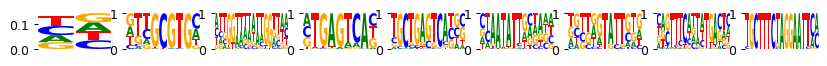

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 76/150 [00:39<00:54,  1.37it/s]

Epoch: 76, Loss: 227.024902, R2: 0.38,  best epoch: 74,  secs per epoch: 0.521 s,  secs epoch*1k trials: 5.207s curr time: 2024-05-08 08:33:38.085847


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:12<00:00,  2.08it/s]


Final loss: 191.6574249268 , R2: 0.40
Total time (model/function): (72.048s / 72.048s)
Time per epoch (model/function): (0.484s/ 0.484s)
Time per epoch per 1k trials: 4.835s
Current time: 2024-05-08 08:34:11.925154
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


Final loss: 175.8582916260 , R2: 0.40
Total time (model/function): (99.556s / 27.508s)
Time per epoch (model/function): (2.032s/ 0.561s)
Time per epoch per 1k trials: 5.614s
Current time: 2024-05-08 08:34:40.237002


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


Final loss: 161.8743591309 , R2: 0.40
Total time (model/function): (125.028s / 25.472s)
Time per epoch (model/function): (2.552s/ 0.520s)
Time per epoch per 1k trials: 5.198s
Current time: 2024-05-08 08:35:06.431109
best loss 161.87435913085938
current r2 values by newly added filter
[0.40272220168921136]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 3 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 3 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.38it/s]


Final loss: 159.1855316162 , R2: 0.40
Total time (model/function): (161.197s / 36.169s)
Time per epoch (model/function): (3.290s/ 0.738s)
Time per epoch per 1k trials: 7.381s
Current time: 2024-05-08 08:35:43.873876


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


Final loss: 151.3673553467 , R2: 0.40
Total time (model/function): (221.567s / 60.370s)
Time per epoch (model/function): (4.522s/ 1.232s)
Time per epoch per 1k trials: 12.320s
Current time: 2024-05-08 08:36:44.952279
best loss 151.3673553466797
current r2 values by newly added filter
[0.40272220168921136, 0.4029424506848299]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 4 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 4 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


Final loss: 152.5921020508 , R2: 0.40
Total time (model/function): (274.396s / 52.829s)
Time per epoch (model/function): (5.600s/ 1.078s)
Time per epoch per 1k trials: 10.781s
Current time: 2024-05-08 08:37:39.377576


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Final loss: 147.2454681396 , R2: 0.40
Total time (model/function): (327.989s / 53.593s)
Time per epoch (model/function): (6.694s/ 1.094s)
Time per epoch per 1k trials: 10.937s
Current time: 2024-05-08 08:38:33.691503
best loss 147.24546813964844
current r2 values by newly added filter
[0.40272220168921136, 0.4029424506848299, 0.40369910942545495]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 327.9885835647583s
Time per epoch (total): 0.023 s
True
12
order None
0 out of 288...
break


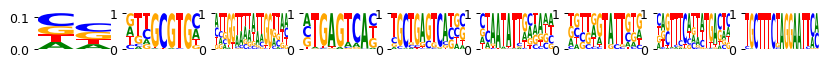

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 76/150 [00:21<00:43,  1.71it/s]

Epoch: 76, Loss: 226.995956, R2: 0.41,  best epoch: 74,  secs per epoch: 0.284 s,  secs epoch*1k trials: 2.836s curr time: 2024-05-08 08:38:58.525551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:16<00:00,  1.96it/s]


Final loss: 191.6530303955 , R2: 0.43
Total time (model/function): (76.344s / 76.344s)
Time per epoch (model/function): (0.512s/ 0.512s)
Time per epoch per 1k trials: 5.124s
Current time: 2024-05-08 08:39:54.514095
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.56s/it]


Final loss: 175.8556213379 , R2: 0.44
Total time (model/function): (154.495s / 78.151s)
Time per epoch (model/function): (3.153s/ 1.595s)
Time per epoch per 1k trials: 15.949s
Current time: 2024-05-08 08:41:13.926095


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.18it/s]


Final loss: 161.8718872070 , R2: 0.45
Total time (model/function): (196.890s / 42.395s)
Time per epoch (model/function): (4.018s/ 0.865s)
Time per epoch per 1k trials: 8.652s
Current time: 2024-05-08 08:41:57.263050
best loss 161.87188720703125
current r2 values by newly added filter
[0.41189017791163873]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 3 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 3 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.20it/s]


Final loss: 159.1826019287 , R2: 0.43
Total time (model/function): (238.594s / 41.704s)
Time per epoch (model/function): (4.869s/ 0.851s)
Time per epoch per 1k trials: 8.511s
Current time: 2024-05-08 08:42:40.949684


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Final loss: 151.3643646240 , R2: 0.40
Total time (model/function): (287.343s / 48.749s)
Time per epoch (model/function): (5.864s/ 0.995s)
Time per epoch per 1k trials: 9.949s
Current time: 2024-05-08 08:43:32.924269
best loss 151.36436462402344
current r2 values by newly added filter
[0.41189017791163873, 0.4228487009090335]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 4 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 4 to (1, 0)
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


Final loss: 152.5926971436 , R2: 0.42
Total time (model/function): (358.985s / 71.642s)
Time per epoch (model/function): (7.326s/ 1.462s)
Time per epoch per 1k trials: 14.621s
Current time: 2024-05-08 08:44:46.820420


final refinement step (after shift)...

unfreezing all layers for final refinement
filters mask None
filters mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
use_tqdm True


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.21it/s]


Final loss: 147.2394409180 , R2: 0.41
Total time (model/function): (400.188s / 41.203s)
Time per epoch (model/function): (8.167s/ 0.841s)
Time per epoch per 1k trials: 8.409s
Current time: 2024-05-08 08:45:29.273743
best loss 147.23944091796875
current r2 values by newly added filter
[0.41189017791163873, 0.4228487009090335, 0.41430273797494577]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 400.187650680542s
Time per epoch (total): 0.028 s


In [99]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 50
log_each=75

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [100]:
%load_ext line_profiler

In [101]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [102]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [103]:
# model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
#                                             show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
#                                             opt_kernel_shift=[0, 0] + [0] * (n_kernels),
#                                             opt_kernel_length=[0, 0] + [0] * (n_kernels),
#                                             opt_one_step=True,
#                                             shift_max=1, shift_step=1, optimiser=topti.Adam,
#                                             skip_kernels=range(0, len(model.binding_modes) - 1),
#                                             n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
#                                             kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
#                                             exp_max=8,
#                                             early_stopping=250, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

True
True
3
order None
0 out of 288...
break


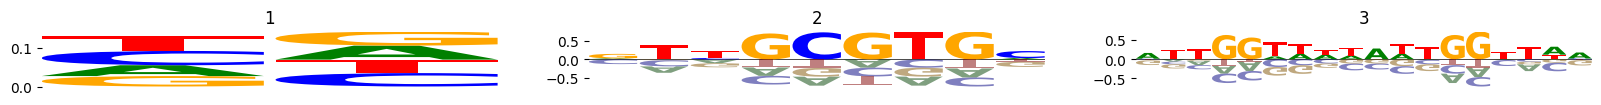

False
True
3
order None
0 out of 288...
break


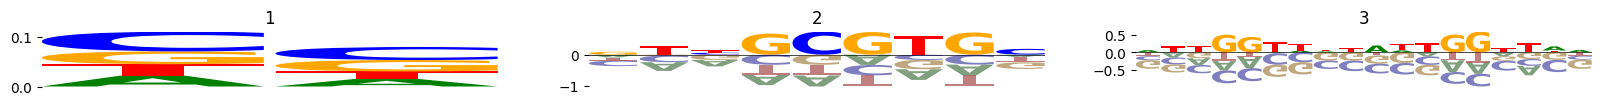

In [104]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


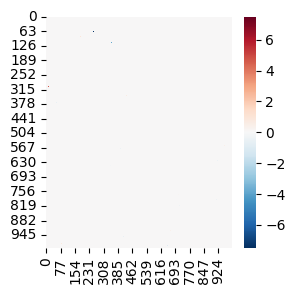

In [105]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [106]:
model = model_by_logdynamic[1]

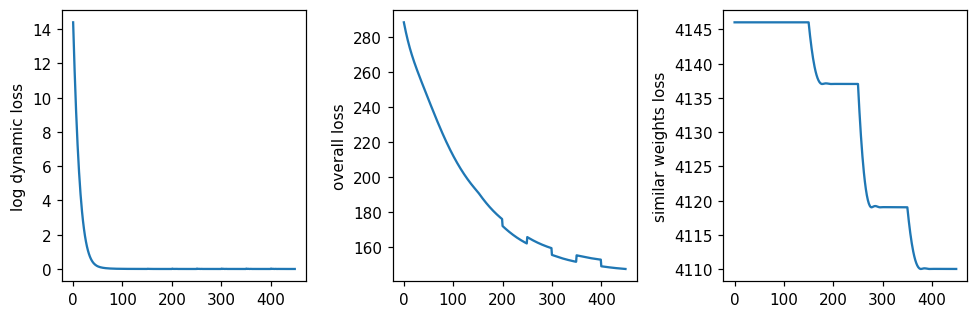

In [107]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [108]:
model_by_logdynamic

{True: Mubind(
   (padding): ConstantPad2d(padding=(23, 23, 0, 0), value=0.25)
   (binding_modes): BindingModesSimple(
     (conv_mono): ModuleList(
       (0): None
       (1): Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
       (2): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (3): Conv2d(1, 1, kernel_size=(4, 18), stride=(1, 1), bias=False)
       (4): Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
       (5): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (6): Conv2d(1, 1, kernel_size=(4, 14), stride=(1, 1), bias=False)
       (7): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (8-9): 2 x Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
       (10): Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
       (11): Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
       (12): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
       (13): Conv2d(1, 1,

True
False


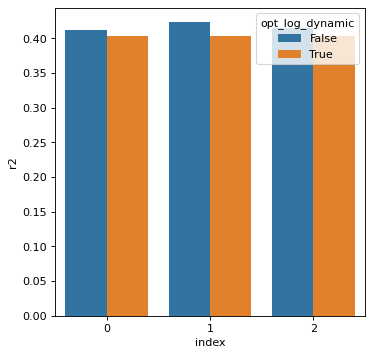

In [109]:
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 5, 5
    rcParams['figure.dpi'] = 80
    sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic')
    plt.show()

In [110]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [111]:


#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
# mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
# sns.displot(dynamic_score, height=3, aspect=1.2)
# plt.xlabel('dynamic score (normalized)')


In [112]:
ad.obs['dynamic_score'].describe()

count    1000.000000
mean        0.500368
std         0.060169
min         0.000000
25%         0.500346
50%         0.500368
75%         0.500396
max         1.000000
Name: dynamic_score, dtype: float64

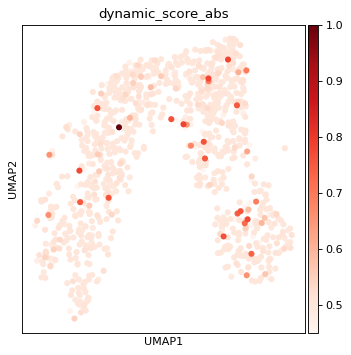

In [113]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

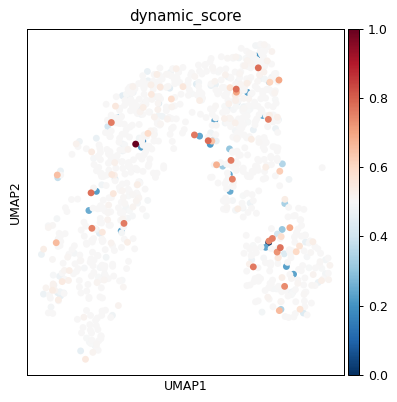

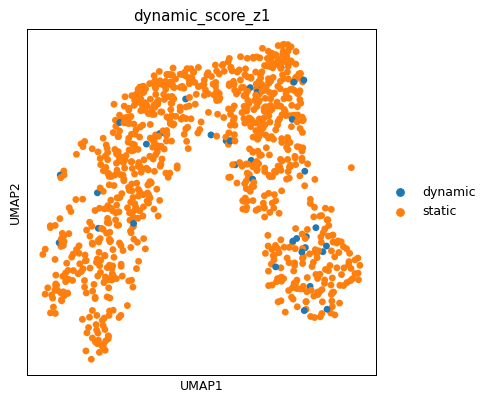

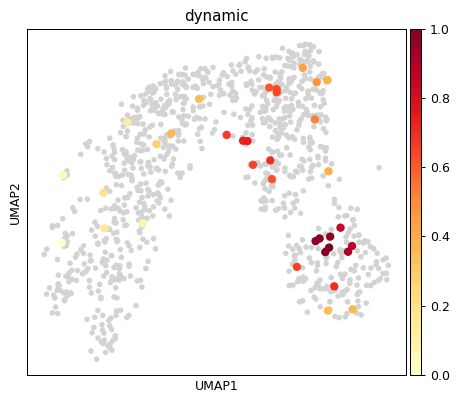

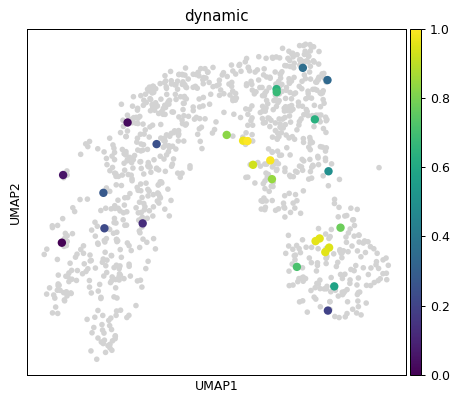

In [114]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

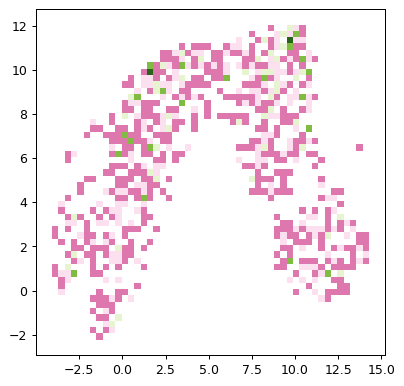

In [115]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

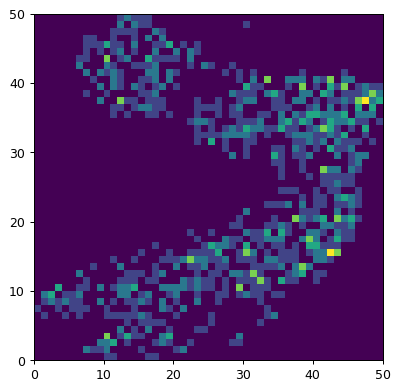

In [116]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [117]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [118]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


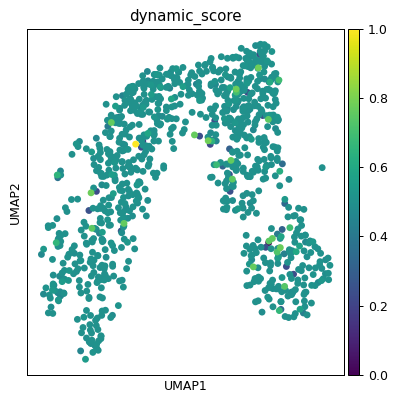

In [119]:
sc.pl.umap(ad, color='dynamic_score')

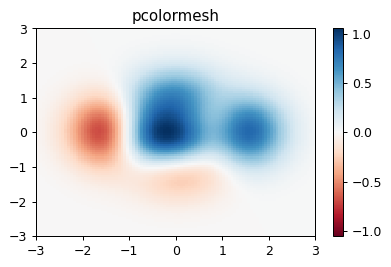

In [120]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [121]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [122]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs['celltype'].cat.codes.values, size_x=1, size_y=1)

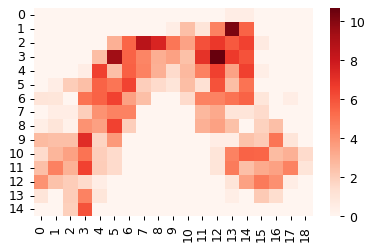

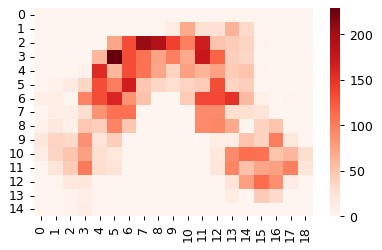

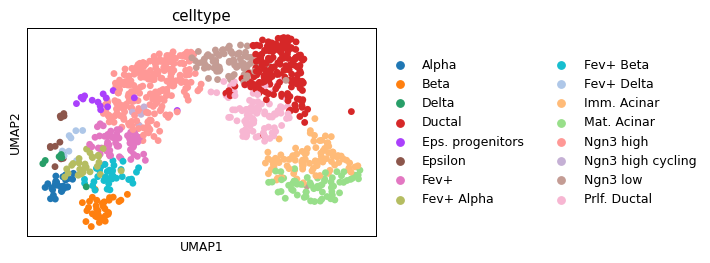

In [123]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color='celltype')

True


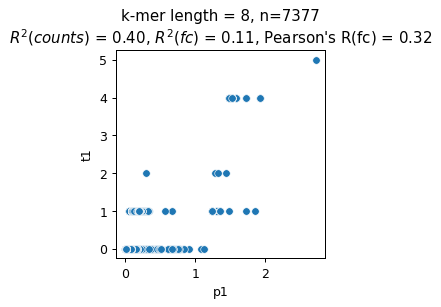

True
3
order None
0 out of 288...
10 out of 288...
break


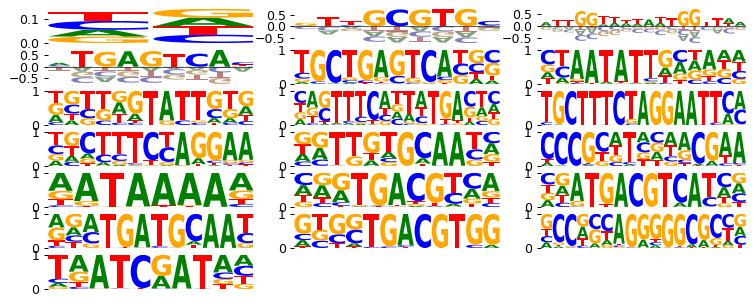

False


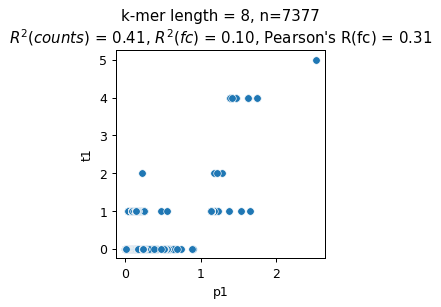

True
3
order None
0 out of 288...
10 out of 288...
break


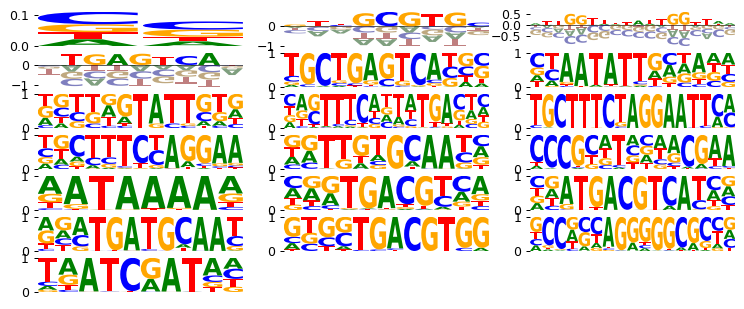

In [124]:
for optimize_log_dynamic in model_by_logdynamic:
    mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
    plt.show()

    mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=12,
               n_cols=3,
               stop_at=20) # n_cols=len(reduced_groups))
    plt.show()


In [125]:
model = model_by_logdynamic[True]

In [126]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [127]:
len(G[G > 0])

1314

In [128]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [129]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

True
here...
(100, 1000)
255803930000.0
False


In [130]:
X = ad.X.A

In [131]:
G @ binding_scores

tensor([[      0.00,       0.00,       0.00,  ...,       0.00,       0.00,
               0.00],
        [      0.00,       0.00,       0.00,  ...,       0.00,       0.00,
               0.00],
        [ 734362.38, 1012020.06,  789327.00,  ...,  714162.81,  726631.75,
          722563.00],
        ...,
        [ 925237.06, 1270587.50,  993658.00,  ...,  899783.88,  915505.25,
          910202.50],
        [      0.00,       0.00,       0.00,  ...,       0.00,       0.00,
               0.00],
        [ 545054.12,  751129.12,  585878.19,  ...,  530011.00,  539383.81,
          536311.75]])

In [132]:
np.random.shuffle(binding_scores)

In [134]:
import scvelo as scv

In [136]:
ad

AnnData object with n_obs × n_vars = 1000 × 100
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    layers: 'velocity'
 

In [137]:
ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [138]:
np.random.shuffle(binding_scores)
binding_scores

array([[2324514. , 3189129. , 2495252.2, ..., 2260022.5, 2299915. ,
        2286148.2],
       [2333094.5, 3206710.5, 2505681.2, ..., 2268284.5, 2308467.5,
        2294896.5],
       [2348381. , 3242888.5, 2524614. , ..., 2283432.5, 2323886.2,
        2310620. ],
       ...,
       [2345518. , 3235143.8, 2521094. , ..., 2280798.5, 2320989. ,
        2307781.5],
       [2334645.5, 3216877. , 2508612. , ..., 2270244.2, 2310534.2,
        2296917. ],
       [2348381. , 3242888.5, 2524614. , ..., 2283432.5, 2323886.2,
        2310620. ]], dtype=float32)

In [139]:
import scvelo as scv

In [151]:
ad

AnnData object with n_obs × n_vars = 1000 × 100
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'modality', 'acc_score', 'acc_score_rank', 'chr', 'start', 'end', 'summit', 'summit.start', 'summit.end', 'k.summit'
    uns: 'celltype_colors', 'neighbors', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    layers: 'velocity'
 

In [152]:
np.random.shuffle(binding_scores)
ad.layers['velocity'] = binding_scores
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.


KeyError: 'spliced'

<Axes: >

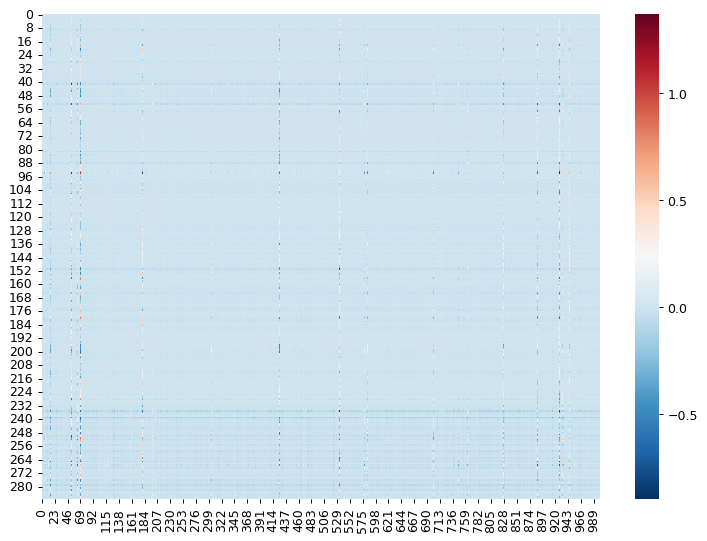

In [142]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r')

In [150]:
scv.tl.velocity_graph(ad)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.


KeyError: 'spliced'

In [143]:

ax = scv.pl.velocity_embedding_stream(ad,
                                      color='celltype',
                                      # density=2,
                                      arrow_color='black',
                                      n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

computing velocity embedding


ValueError: You need to run `tl.velocity_graph` first to compute cosine correlations.

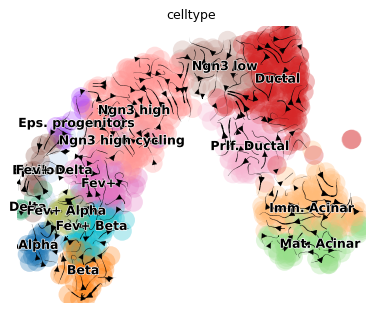

In [ ]:
ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [ ]:
print('here...')

here...


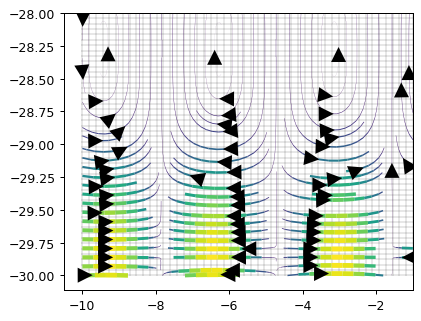

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10,-1, 50)
y = np.linspace(-30, -28, 50)

xi, yi = np.meshgrid(x,y)

u =  3*np.cos(xi)*((-3)*np.sin(yi))**3
v = 2*np.sin(xi)*3*np.cos(yi)
speed = np.sqrt((u**2)+(v**2))

lw = 4*speed/speed.max()

plt.ion()
plt.figure()
plt.plot(xi,yi,'-k',alpha=0.1)
plt.plot(xi.T,yi.T,'-k',alpha=0.1)
c = plt.streamplot(xi,yi,u,v,linewidth=lw,color=speed)

import matplotlib.patches

# get the axes (note that you should actually capture this when creating the subplot)
ax = plt.gca()

# iterate through the children of ax
for art in ax.get_children():
    # we are only interested in FancyArrowPatches
    if not isinstance(art, matplotlib.patches.FancyArrowPatch):
        continue
    # remove the edge, fill with black
    art.set_edgecolor([0, 0, 0, 0])
    art.set_facecolor([0, 0, 0, 1])
    # make it bigger
    art.set_mutation_scale(30)
    # move the arrow head to the front
    art.set_zorder(10)

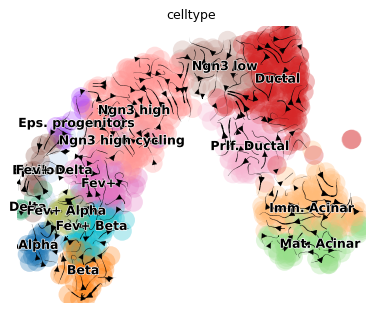

In [ ]:
scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

In [ ]:
rna = sc.read_h5ad(rna_path)
rna.shape
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape
anno = mb.datasets.archetypes_anno()

In [ ]:
rna_sel.shape

(1000, 14663)

True


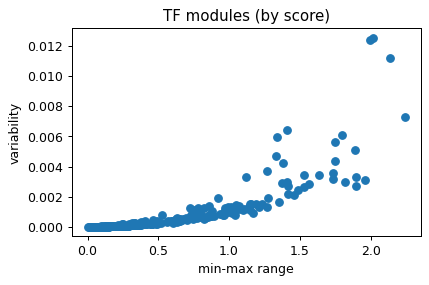

In [ ]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

In [ ]:
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


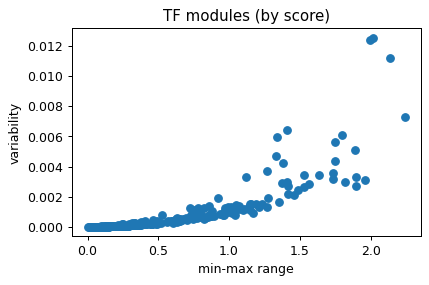

In [ ]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])


In [ ]:
res.sort_values('spearman', ascending=False)

,opt_log_dynamic,archetype_id,spearman,p_val
259,True,258,0.102863,0.001124
3,True,2,0.101785,0.001268
214,True,213,0.095893,0.002400
177,True,176,0.087666,0.005535
0,True,intercept,0.086604,0.006137
...,...,...,...,...
200,True,199,-0.045956,0.146447
199,True,198,-0.051906,0.100909
258,True,257,-0.060003,0.057856
63,True,62,-0.060199,0.057040


In [ ]:
res = pd.DataFrame(pd.concat([delta, var], axis=1))
res['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
res['archetypes_name'] = res['name'].map(anno.set_index('Cluster_ID')['Name'])
res['archetypes_seed'] = res['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
res = res.sort_values(0, ascending=0)
res

,0,1,name,archetypes_name,archetypes_seed
92,2.240767,7.297182e-03,92,SOX/3,SOX10_HMG_4
238,2.133948,1.120162e-02,238,PROX1,PROX1_MA0794.1
40,2.015678,1.254256e-02,40,NR/11,ERR2_MOUSE.H11MO.0.A
266,1.996962,1.240762e-02,266,INSM1,INSM1_HUMAN.H11MO.0.C
197,1.958033,3.133713e-03,197,ZNF586,ZN586_HUMAN.H11MO.0.C
...,...,...,...,...,...
1,0.022426,4.621574e-07,1,HD/1,LHX6_homeodomain_3
158,0.020998,1.013655e-06,158,E2F/4,E2F2_HUMAN.H11MO.0.B
114,0.019424,4.578877e-07,114,MZF1,MZF1_HUMAN.H11MO.0.B
dinuc_bias,0.011570,1.343721e-07,dinuc_bias,NaN,NaN


<Axes: xlabel='0', ylabel='archetypes_name'>

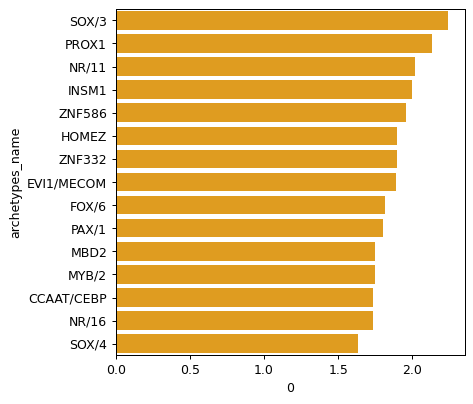

In [ ]:
rcParams['figure.figsize'] = 5, 5
sns.barplot(data=res.head(15), x=0, y='archetypes_name', color='orange')

In [ ]:
res.head(20)

,0,1,name,archetypes_name,archetypes_seed
92,2.240767,0.007297,92,SOX/3,SOX10_HMG_4
238,2.133948,0.011202,238,PROX1,PROX1_MA0794.1
40,2.015678,0.012543,40,NR/11,ERR2_MOUSE.H11MO.0.A
266,1.996962,0.012408,266,INSM1,INSM1_HUMAN.H11MO.0.C
197,1.958033,0.003134,197,ZNF586,ZN586_HUMAN.H11MO.0.C
195,1.898823,0.003283,195,HOMEZ,HOMEZ_HOMEZ_1
152,1.895684,0.002701,152,ZNF332,ZN322_HUMAN.H11MO.0.B
241,1.888398,0.005106,241,EVI1/MECOM,EVI1_HUMAN.H11MO.0.B
87,1.818653,0.002971,87,FOX/6,FOXB1_forkhead_2
281,1.800020,0.006076,281,PAX/1,PAX1_MA0779.1


True
1
order None
0 out of 288...
10 out of 288...
break


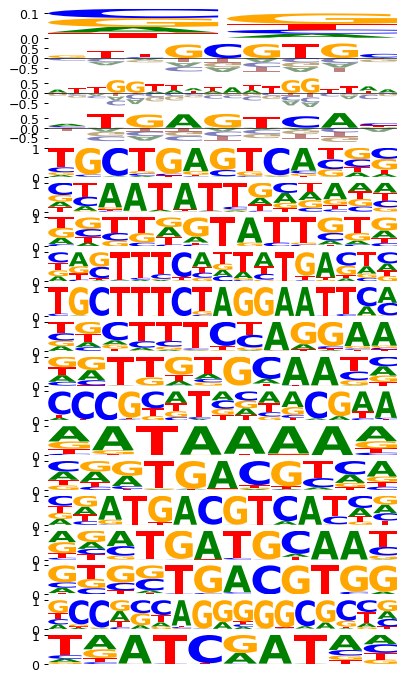

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([ 92, 238,  40, 266, 197, 195, 152, 241,  87, 281, 239, 254,  52,  45,
        93, 279,  44, 251, 179, 174],
      dtype='object')
0 out of 288...
10 out of 288...


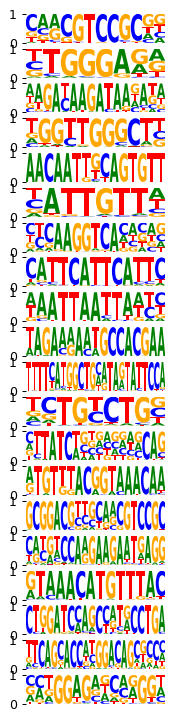

<Figure size 180x1800 with 0 Axes>

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 9.231172


In [ ]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [ ]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [ ]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [ ]:
from scipy.stats import spearmanr

In [ ]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')

res = []
print(len(all_targets))
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    log_act = ad.obsm['log_activities'][k].values
    for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
        # print(ki)
        if ki % 10 == 0:
            print(ki)
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        # for t in all_targets:
        for t in set(all_targets).intersection(next_targets):
            gex = rna_sel.X[:,rna_sel.var_names == t]
            assert gex.shape[1] == 1
            gex = gex.A.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

True
3828
True
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


In [ ]:
res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())

In [ ]:
res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj


In [ ]:
res

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
0,True,2,Isl1,True,-0.047252,0.135386,HD/2,0.879924
1,True,2,Gen1,True,0.027024,0.393296,HD/2,0.935144
2,True,2,Pax4,True,0.016289,0.606914,HD/2,0.970401
3,True,2,Mnx1,True,0.019239,0.543397,HD/2,0.962173
4,True,2,Tsen15,True,0.017616,0.577919,HD/2,0.962946
...,...,...,...,...,...,...,...,...
4392,True,281,Pax2,True,0.057506,0.069107,PAX/1,0.845494
4393,True,281,Pax6,True,-0.029126,0.357531,PAX/1,0.926647
4394,True,283,Pax2,True,0.057506,0.069107,PAX-halfsite,0.845494
4395,True,284,Ahr,True,-0.018589,0.557094,AHR,0.962173


In [ ]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')


In [ ]:
res.pivot(index='k', columns='opt_log_dynamic', values='matched')

opt_log_dynamic,True
k,
A3galt2_70,True
Aar2_248,True
Aard_248,True
Aars2_248,True
Aars_248,True
...,...
mt-Nd3_70,True
mt-Nd4_70,True
mt-Nd4l_70,True


In [ ]:
df2['matched'] = res.pivot(index='k', columns='opt_log_dynamic', values='matched')[True]

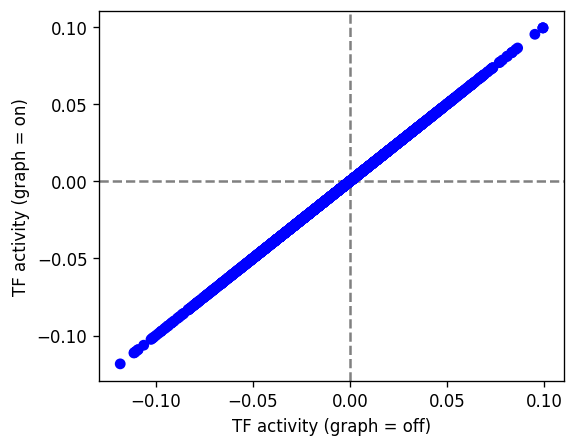

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
df2 = df2.sort_values('matched', ascending=True)
plt.scatter(df2[True], df2[True],
            color=np.where(df2['matched'], 'blue', 'gray'),
            s=np.where(df2['matched'], 30, 5))
plt.xlabel('TF activity (graph = off)')
plt.ylabel('TF activity (graph = on)')
plt.axhline(0, color='gray', ls='--', zorder=0)
plt.axvline(0, color='gray', ls='--', zorder=0)


In [ ]:
df2[df2['matched'] == True].sort_values(True, ascending=False)

opt_log_dynamic,True,matched
k,,
Pparg_248,0.099312,True
Pparg_32,0.099312,True
Pparg_46,0.099312,True
mt-Co3_70,0.095160,True
Tspan12_70,0.086279,True
...,...,...
Tlk2_70,-0.110251,True
Rhot1_70,-0.110827,True
Rmst_70,-0.111110,True


True


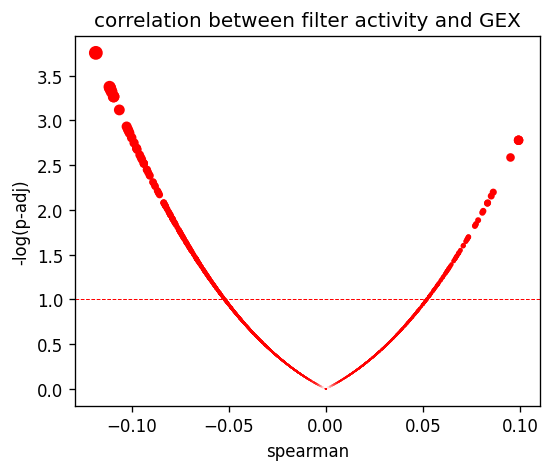

In [ ]:
for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    print(optimize_log_dynamic)
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 3), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('correlation between filter activity and GEX')
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

In [ ]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

In [ ]:
res[res['p_val'] < 0.1]

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
12,True,2,Psen2,True,-0.060164,0.057186,HD/2,0.816544,Psen2_2
16,True,2,Nkx6-2,True,0.062389,0.048568,HD/2,0.808784,Nkx6-2_2
21,True,2,Tsen2,True,0.083264,0.008430,HD/2,0.718826,Tsen2_2
32,True,2,Abraxas1,True,0.065952,0.037048,HD/2,0.775720,Abraxas1_2
44,True,10,Hnf1b,True,-0.070107,0.026628,HD/10,0.775720,Hnf1b_10
...,...,...,...,...,...,...,...,...,...
4358,True,257,Zfp53,True,0.053070,0.093482,P53-like/1,0.856269,Zfp53_257
4369,True,261,Glis1,True,0.059285,0.060920,GLIS,0.829750,Glis1_261
4382,True,264,Ap2a2,True,-0.118369,0.000176,TFAP2/1,0.340351,Ap2a2_264
4392,True,281,Pax2,True,0.057506,0.069107,PAX/1,0.845494,Pax2_281


In [ ]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [ ]:
# sc.pl.umap(rna_sel, color=sel_genes,
#            cmap='Reds', ncols=3)


In [ ]:
import anndata
ad_act = anndata.AnnData(ad.obsm['log_activities'])
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

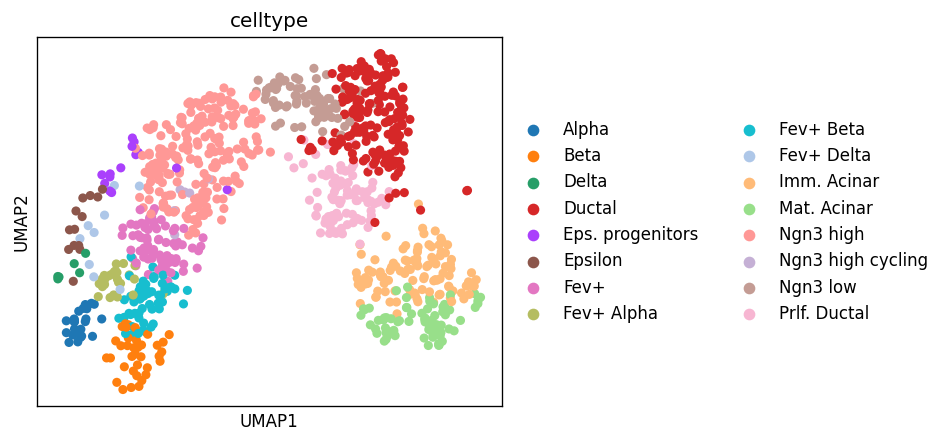

In [ ]:
sc.pl.umap(ad_act, color='celltype')


Rank genes groups using the annotation

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
rkg_df = []
for ct in ad_act.obs['celltype'].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2['celltype'] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Fev+
Imm. Acinar
Fev+ Beta
Prlf. Ductal
Ngn3 high
Eps. progenitors
Ngn3 low
Ductal
Alpha
Fev+ Alpha
Fev+ Delta
Beta
Delta
Epsilon
Ngn3 high cycling
Mat. Acinar


,names,scores,logfoldchanges,pvals,pvals_adj,celltype,module_name
0,234,0.902213,NaN,0.369763,0.698411,Fev+,234
1,175,0.887590,2.886426,0.377581,0.698411,Fev+,175
2,31,0.884182,0.722297,0.376919,0.698411,Fev+,31
3,195,0.837134,NaN,0.405065,0.717912,Fev+,195
4,238,0.815456,-0.486590,0.417113,0.717912,Fev+,238


Get top modules

In [ ]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

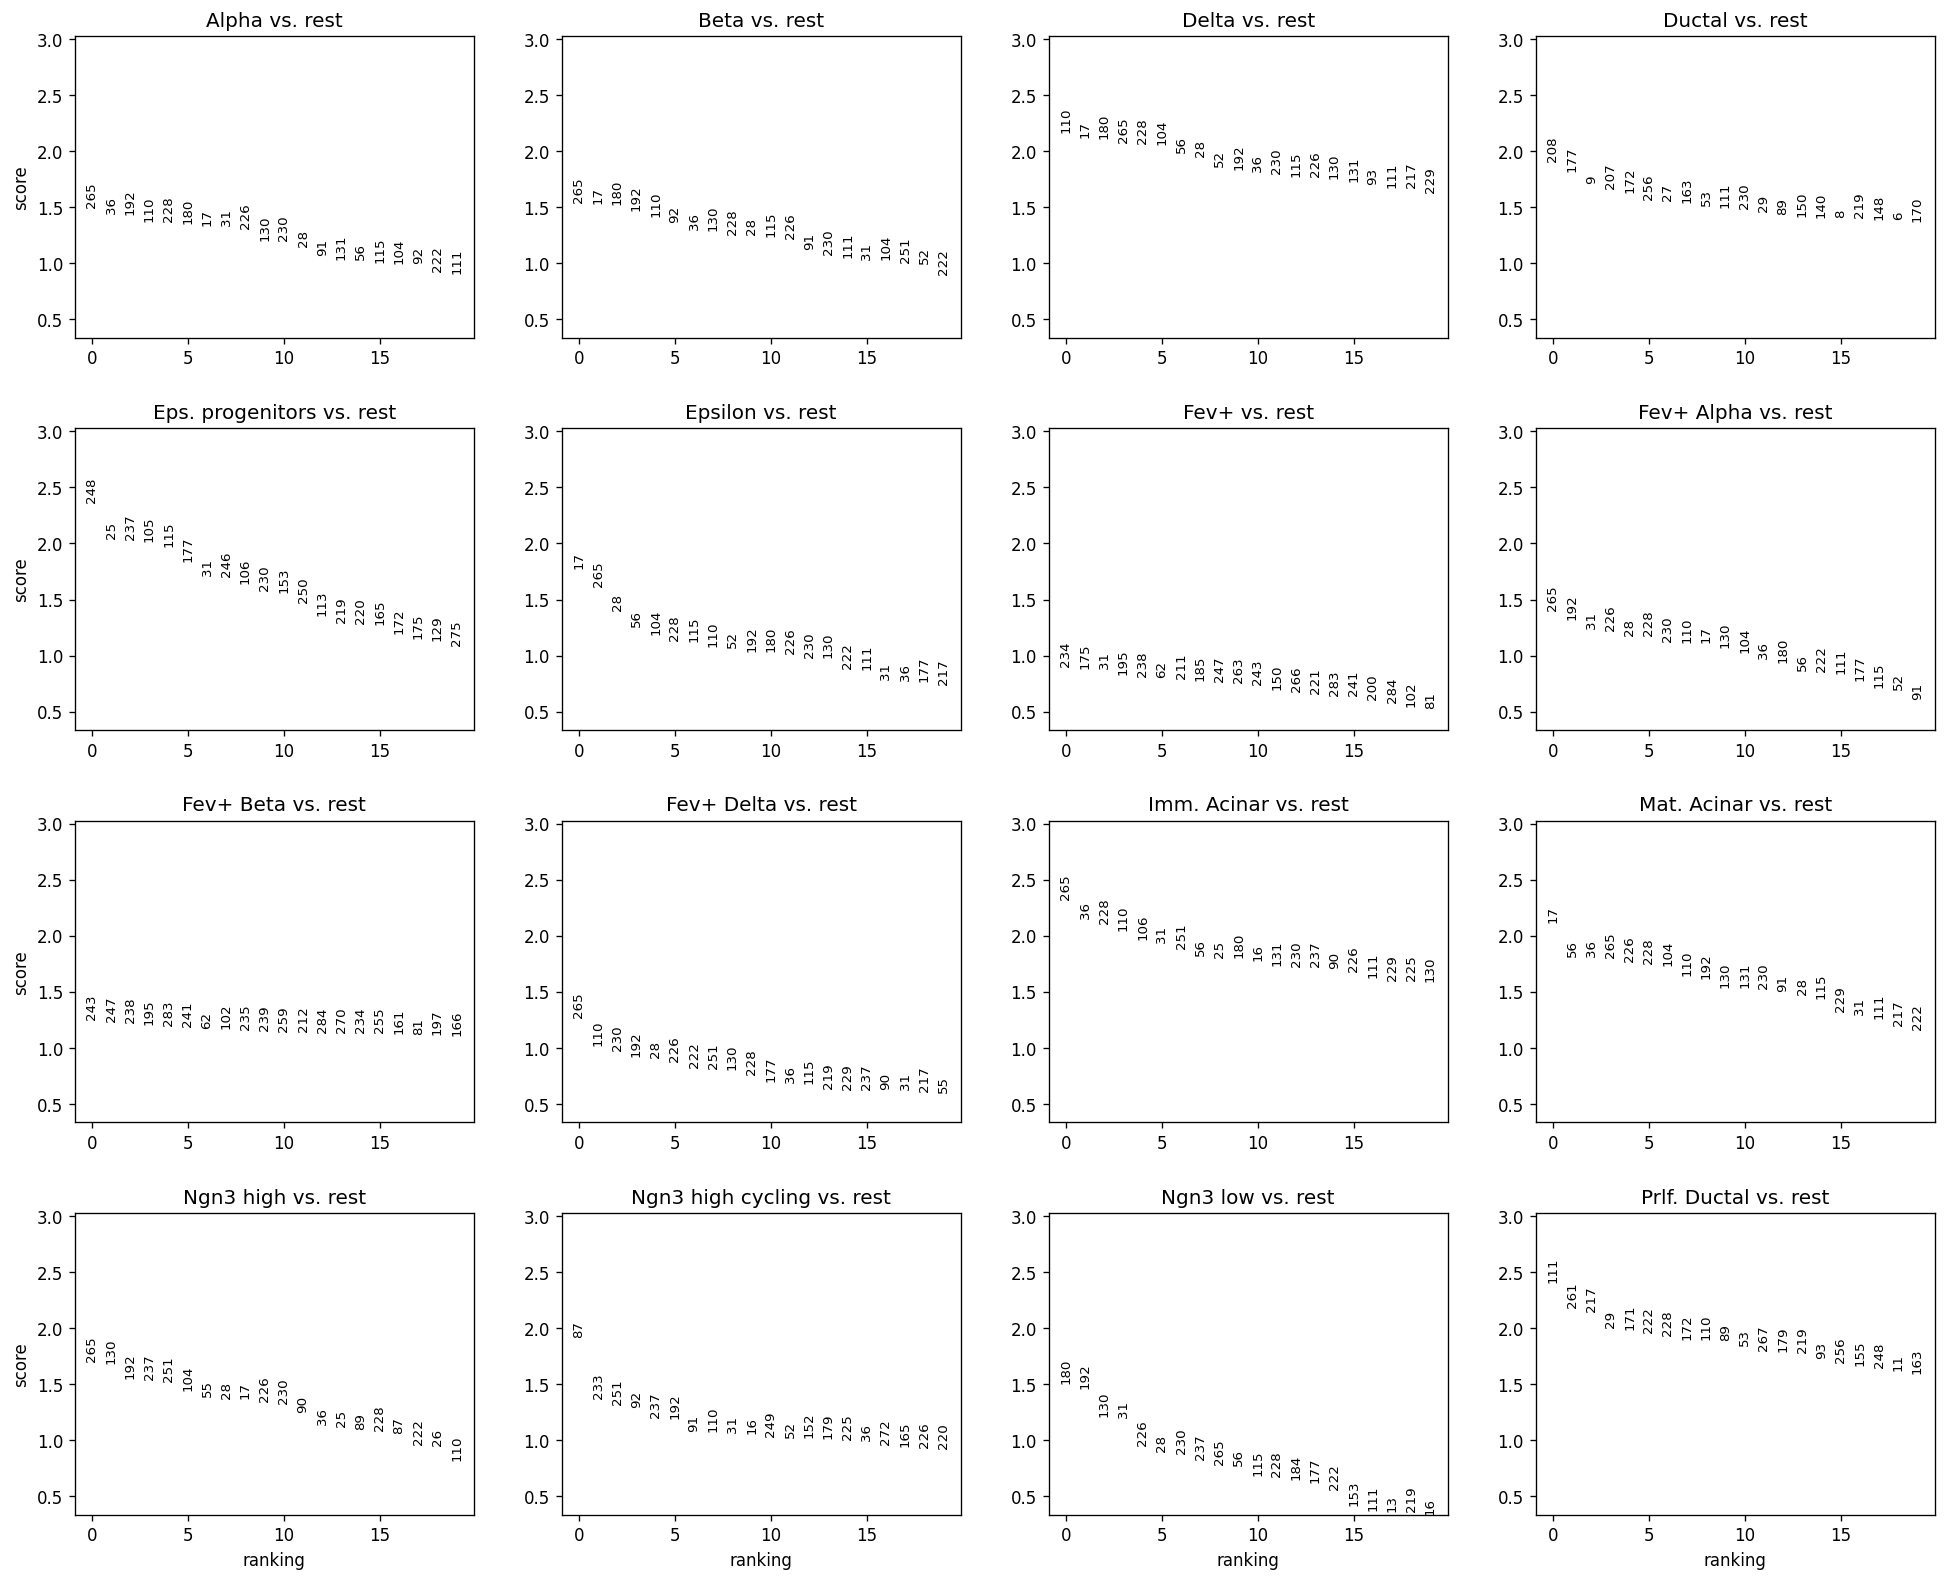

In [ ]:
sc.tl.rank_genes_groups(ad_act, 'celltype')
sc.pl.rank_genes_groups(ad_act)


In [ ]:
len(set(res[(res['p_adj'] < 1e-5)]['k']))

0

In [ ]:
set(res[(res['p_adj'] < 1e-5)]['k'])

set()

In [ ]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
21,True,2,Tsen2,True,0.083264,0.008430,HD/2,0.718826,Tsen2_2
44,True,10,Hnf1b,True,-0.070107,0.026628,HD/10,0.775720,Hnf1b_10
32,True,2,Abraxas1,True,0.065952,0.037048,HD/2,0.775720,Abraxas1_2
16,True,2,Nkx6-2,True,0.062389,0.048568,HD/2,0.808784,Nkx6-2_2
12,True,2,Psen2,True,-0.060164,0.057186,HD/2,0.816544,Psen2_2
0,True,2,Isl1,True,-0.047252,0.135386,HD/2,0.879924,Isl1_2
70,True,24,Arid3a,True,0.047469,0.133593,HD/18,0.879924,Arid3a_24
11,True,2,Shox2,True,0.043002,0.174218,HD/2,0.888295,Shox2_2
6,True,2,Pou6f2,True,-0.041588,0.188833,HD/2,0.888328,Pou6f2_2
3898,True,204,Irx2,True,-0.041239,0.192566,HD/23,0.897167,Irx2_204


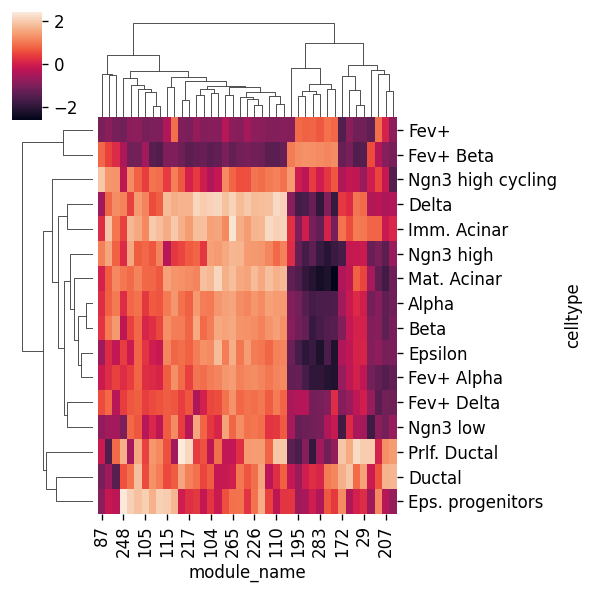

In [ ]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby('celltype').head(5)['module_name'])
sns.clustermap(rkg_df[rkg_df['module_name'].isin(mod_names_best)].pivot(index='celltype', columns='module_name', values='scores'), figsize=[5, 5])


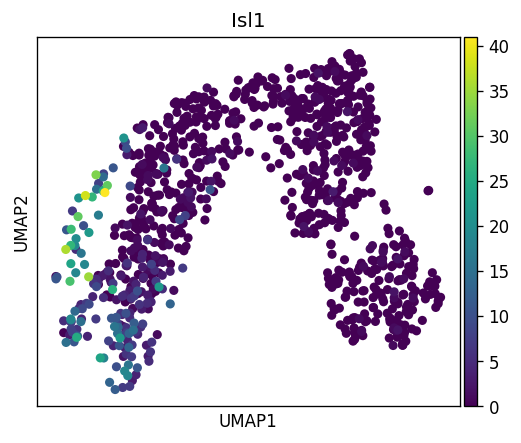

In [ ]:
sc.pl.umap(rna_sel, color='Isl1')


In [ ]:
# rna_sel['Ehf']

In [ ]:
from matplotlib import rcParams, cm
cmap = cm.get_cmap('YlOrRd')
cmap.set_over('black')
cmap.set_under('lightgray')

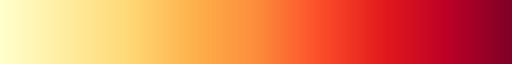

In [ ]:
cmap

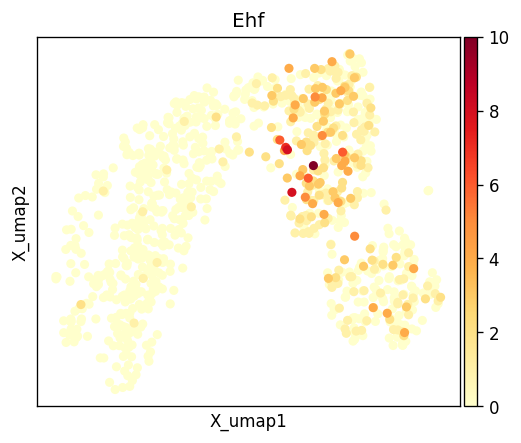

In [ ]:
sc.pl.embedding(rna_sel, basis='X_umap', color='Ehf', color_map=cmap)
